In [6]:
################################################################################
# 1) Imports & Basic Setup
################################################################################
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from scipy import ndimage  # needed for rotate
import SimpleITK as sitk   # needed for 3D elastic transforms

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
################################################################################
# 2) Data Splits (80% / 10% / 10%)
################################################################################
data_dir = "/data/lctsc"  # change to your actual data path
patient_dirs = sorted([p for p in glob(os.path.join(data_dir, "*")) if os.path.isdir(p)])
random.shuffle(patient_dirs)

n_total = len(patient_dirs)
train_count = int(0.8 * n_total)
val_count   = int(0.1 * n_total)

# Remaining 10% for test

train_dirs = patient_dirs[:train_count]
val_dirs   = patient_dirs[train_count : train_count + val_count]
test_dirs  = patient_dirs[train_count + val_count:]
print(f"Train: {len(train_dirs)}, Val: {len(val_dirs)}, Test: {len(test_dirs)}")


Train: 48, Val: 6, Test: 6


In [20]:
################################################################################
# 3) Utility Functions (Windowing, 3D Elastic Deformation)
################################################################################
def window_and_normalize(ct_array, wmin=-1000, wmax=300):
    """
    Clip intensities between [wmin, wmax] and normalize to [0,1].
    """
    clipped = np.clip(ct_array, wmin, wmax)
    return (clipped - wmin) / (wmax - wmin)

def elastic_deform_3d(image, alpha_range=(5,7), sigma_range=(3,4), mode='linear'):
    """
    Apply a random 3D elastic deformation to `image` using SimpleITK.
    - image can be shape (D,H,W) or (D,H,W,1).
    - alpha_range, sigma_range: intensity of the displacement.
    - mode='linear' for continuous images (CT), 'nearest' for masks.
    """
    # Convert to SimpleITK image
    if image.ndim == 4:
        # remove trailing channel
        image_sitk = sitk.GetImageFromArray(image[...,0], isVector=False)
    else:
        image_sitk = sitk.GetImageFromArray(image, isVector=False)
    
    alpha = random.uniform(*alpha_range)
    sigma = random.uniform(*sigma_range)
    
    # Initialize a bspline transform
    transform = sitk.BSplineTransformInitializer(image_sitk, [3,3,3])
    params = np.random.randn(len(transform.GetParameters())) * alpha
    transform.SetParameters(params)
    
    # Choose interpolation based on mode
    if mode == 'nearest':
        interp = sitk.sitkNearestNeighbor
    else:
        interp = sitk.sitkBSpline  # or sitk.sitkLinear
    
    # Resample
    img_deformed_sitk = sitk.Resample(
        image_sitk,
        image_sitk.GetSize(),
        transform,
        interp,
        image_sitk.GetOrigin(),
        image_sitk.GetSpacing(),
        image_sitk.GetDirection(),
        0.0,
        image_sitk.GetPixelID()
    )
    
    # Convert back
    deformed_arr = sitk.GetArrayFromImage(img_deformed_sitk)
    
    # Expand channel dim if original had 4D
    if image.ndim == 4:
        return np.expand_dims(deformed_arr, axis=-1)
    else:
        return deformed_arr

In [9]:
################################################################################
# 4) Data Generator with Flips, Rotations, Elastic
################################################################################
class LungDataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        list_of_dirs,
        batch_size=1,
        augment=True,
        shuffle=True,
        wmin=-1000,
        wmax=300
    ):
        """
        list_of_dirs: List of patient folder paths (ct.nii, lung.nii)
        """
        self.dirs = list_of_dirs
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.wmin = wmin
        self.wmax = wmax
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.dirs) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.dirs)
    
    def __getitem__(self, idx):
        batch_dirs = self.dirs[idx*self.batch_size : (idx+1)*self.batch_size]
        
        x_batch = []
        y_batch = []
        
        for folder in batch_dirs:
            ct_path   = os.path.join(folder, "ct.nii")
            mask_path = os.path.join(folder, "lung.nii")
            
            ct_data   = nib.load(ct_path).get_fdata()
            mask_data = nib.load(mask_path).get_fdata()
            
            # Window & normalize
            ct_data = window_and_normalize(ct_data, self.wmin, self.wmax)
            # Binarize mask
            mask_data = (mask_data > 0).astype(np.float32)
            
            # Augmentation
            if self.augment:
                ct_data, mask_data = self.random_transform_3d(ct_data, mask_data)
            
            # (D,H,W) -> (D,H,W,1)
            ct_data   = np.expand_dims(ct_data, axis=-1)
            mask_data = np.expand_dims(mask_data, axis=-1)
            
            x_batch.append(ct_data)
            y_batch.append(mask_data)
        
        return np.array(x_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)
    
    def random_transform_3d(self, ct, mask):
        """
        Perform random flips, small rotations, plus elastic deformation.
        """
        # Random flips along each axis
        for axis in [0,1,2]:
            if random.random() < 0.5:
                ct = np.flip(ct, axis=axis)
                mask = np.flip(mask, axis=axis)
        
        # Random rotation
        angle_deg = random.uniform(-10, 10)
        axes = random.choice([(0,1), (1,2), (0,2)])
        ct   = ndimage.rotate(ct, angle_deg, axes=axes, reshape=False, order=1, mode='nearest')
        mask = ndimage.rotate(mask, angle_deg, axes=axes, reshape=False, order=0, mode='nearest')
        
        # Random elastic
        if random.random() < 0.5:
            ct   = elastic_deform_3d(ct, alpha_range=(5,7), sigma_range=(3,4), mode='linear')
            mask = elastic_deform_3d(mask, alpha_range=(5,7), sigma_range=(3,4), mode='nearest')
        
        return ct, mask


In [10]:
################################################################################
# 5) Visualizing Augmentations on One Patient
################################################################################
def visualize_augmentation_techniques(folder, generator, slice_idx=32):
    """
    Demonstrate the effect of random_transform_3d on a single patient.
    Apply generator.random_transform_3d(...) multiple times 
    and plot the results.
    """
    ct_path   = os.path.join(folder, "ct.nii")
    mask_path = os.path.join(folder, "lung.nii")
    
    ct_data   = nib.load(ct_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata()
    
    # Window
    ct_data = window_and_normalize(ct_data, -1000, 300)
    mask_data = (mask_data > 0).astype(np.float32)
    
    fig, ax = plt.subplots(3, 2, figsize=(8,8), tight_layout=True)
    fig.suptitle("Augmentation Demonstration", fontsize=16)
    
    # Original
    ax[0,0].imshow(ct_data[..., slice_idx], cmap='bone', vmin=0, vmax=1)
    ax[0,0].set_title("CT Original")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(mask_data[..., slice_idx], cmap='gray')
    ax[0,1].set_title("Mask Original")
    ax[0,1].axis('off')
    
    # Apply the random transform 2 times to see different outputs
    for i in range(2):
        ct_aug, mask_aug = generator.random_transform_3d(ct_data.copy(), mask_data.copy())
        row = i+1
        ax[row,0].imshow(ct_aug[..., slice_idx], cmap='bone', vmin=0, vmax=1)
        ax[row,0].set_title(f"CT Aug {i+1}")
        ax[row,0].axis('off')
        
        ax[row,1].imshow(mask_aug[..., slice_idx], cmap='gray')
        ax[row,1].set_title(f"Mask Aug {i+1}")
        ax[row,1].axis('off')
    
    plt.show()
    plt.close()


In [11]:
################################################################################
# 6) Define Losses & Metrics (Dice, IoU, etc.)
################################################################################
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

def iou_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

import tensorflow.keras.losses as Kloss

def bce_dice_loss(y_true, y_pred):
    bce = Kloss.binary_crossentropy(y_true, y_pred)
    dce = dice_loss(y_true, y_pred)
    return bce + dce

In [12]:
################################################################################
#7) Callbacks for EarlyStopping, ReduceLROnPlateau, + Validation Plot
################################################################################

class ValidationPlotCallback(keras.callbacks.Callback):
    """
    Plot predictions on a chosen validation patient every `epoch_freq` epochs
    using 'viridis' colormap for predicted probability.
    Shows 4 subplots in a row: (1) Pred Probability, (2) Pred Mask, 
    (3) GT Mask, (4) CT.
    """
    def __init__(self, model, val_dir, epoch_freq=5, slice_idx=32):
        super().__init__()
        self.my_model = model  # store the model in a custom attribute
        self.val_dir = val_dir
        self.epoch_freq = epoch_freq
        self.slice_idx = slice_idx
        
        # Load and prepare data once at initialization
        import nibabel as nib
        ct_path = os.path.join(val_dir, "ct.nii")
        mask_path = os.path.join(val_dir, "lung.nii")
        
        ct_data = nib.load(ct_path).get_fdata()
        mask_data = nib.load(mask_path).get_fdata()
        
        self.ct_windowed = window_and_normalize(ct_data, -1000, 300)
        self.mask_bin = (mask_data > 0).astype(np.float32)
        
        # Model expects shape (1, D, H, W, 1)
        tmp = np.expand_dims(self.ct_windowed, axis=-1)  # add channel
        tmp = np.expand_dims(tmp, axis=0)                # add batch
        self.input_data = tmp

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.epoch_freq == 0:
            preds = self.my_model.predict(self.input_data)[0]  # (D,H,W,1)
            pred_bin = (preds > 0.5).astype(np.float32)
            s = self.slice_idx

            fig, axes = plt.subplots(1, 4, figsize=(16, 4), tight_layout=True)
            fig.suptitle(f"Epoch {epoch + 1} - Slice {s}", fontsize=14)

            # (1) Pred Probability
            im0 = axes[0].imshow(preds[..., s, 0].T,
                                 origin='lower', vmin=0, vmax=1, cmap='viridis')
            axes[0].set_title("Pred Probability")
            axes[0].axis('off')
            plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

            # (2) Predicted Mask
            axes[1].imshow(pred_bin[..., s, 0].T, origin='lower', cmap='gray')
            axes[1].set_title("Predicted Mask")
            axes[1].axis('off')

            # (3) Ground Truth Mask
            axes[2].imshow(self.mask_bin[..., s].T, origin='lower', cmap='gray')
            axes[2].set_title("Ground Truth Mask")
            axes[2].axis('off')

            # (4) CT
            axes[3].imshow(self.ct_windowed[..., s].T, origin='lower', cmap='viridis')
            axes[3].set_title("CT")
            axes[3].axis('off')

            plt.show()
            plt.close()
            

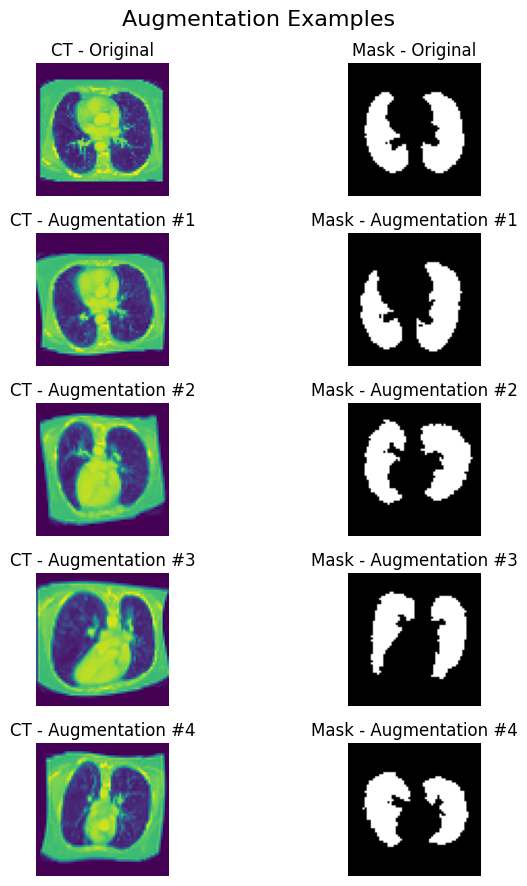

In [13]:
################################################################################
# 8) Data Generator Instantiation & Augmentation Visualization (Colorful)
################################################################################

def visualize_augmentation_techniques(folder, generator, slice_idx=32):
    """
    Demonstrate random 3D augmentations (flip, rotation, elastic, etc.) 
    on a single patient's image. Plots in a 'viridis' colormap for the CT 
    to highlight purple->yellow intensities.
    """
    ct_path = os.path.join(folder, "ct.nii")
    mask_path = os.path.join(folder, "lung.nii")
    
    ct_data = nib.load(ct_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata()
    
    # Window and binarize
    ct_data = window_and_normalize(ct_data, -1000, 300)
    mask_data = (mask_data > 0).astype(np.float32)
    
    # Original
    fig, ax = plt.subplots(5, 2, figsize=(8, 9), tight_layout=True)
    fig.suptitle("Augmentation Examples", fontsize=16)
    
    ax[0,0].imshow(ct_data[..., slice_idx].T, origin='lower', cmap='viridis', vmin=0, vmax=1)
    ax[0,0].set_title("CT - Original")
    ax[0,0].axis('off')
    ax[0,1].imshow(mask_data[..., slice_idx].T, origin='lower', cmap='gray')
    ax[0,1].set_title("Mask - Original")
    ax[0,1].axis('off')
    
    # We'll apply the random transform 4 times to show differences
    for i in range(4):
        # Copy data for augmentation
        ct_aug, mask_aug = generator.random_transform_3d(
            ct_data.copy(), 
            mask_data.copy()
        )
        
        row = i + 1
        ax[row, 0].imshow(ct_aug[..., slice_idx].T, origin='lower', cmap='viridis', vmin=0, vmax=1)
        ax[row, 0].set_title(f"CT - Augmentation #{i+1}")
        ax[row, 0].axis('off')
        
        ax[row, 1].imshow(mask_aug[..., slice_idx].T, origin='lower', cmap='gray')
        ax[row, 1].set_title(f"Mask - Augmentation #{i+1}")
        ax[row, 1].axis('off')
    
    plt.show()
    plt.close()

# Usage for seeing augmentations:
temp_gen = LungDataGenerator(train_dirs, augment=True, shuffle=False)
# Show how the random transforms look for the second training patient
visualize_augmentation_techniques(train_dirs[1], temp_gen, slice_idx=32)

In [14]:
################################################################################
# 9) Model Architecture (3D U-Net)
################################################################################

from tensorflow.keras import layers

def conv_block_3d(x, filters, kernel_size=3, weight_decay=1e-5, dropout_rate=0.0):
    """
    A basic 3D convolution block with two Conv3D + BN + ReLU steps.
    Includes Dropout and L2 regularization.
    """
    reg = keras.regularizers.l2(weight_decay)

    # First Conv
    x = layers.Conv3D(filters, kernel_size, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Dropout
    if dropout_rate > 0.0:
        x = layers.Dropout(dropout_rate)(x)

    # Second Conv
    x = layers.Conv3D(filters, kernel_size, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x


def unet_3d_5levels(
    input_shape=(64,64,64,1),
    base_filters=16,
    dropout_rate=0.2,
    weight_decay=1e-5
):
    """
    A 3D U-Net with 5 levels of encoder-decoder depth.
    More capacity, but higher memory requirements.
    """
    inputs = layers.Input(shape=input_shape)

    # -------------------- Encoder --------------------
    # Level 1
    c1 = conv_block_3d(inputs, base_filters, dropout_rate=dropout_rate, weight_decay=weight_decay)
    p1 = layers.MaxPooling3D(pool_size=(2,2,2))(c1)  # 64 -> 32

    # Level 2
    c2 = conv_block_3d(p1, base_filters*2, dropout_rate=dropout_rate, weight_decay=weight_decay)
    p2 = layers.MaxPooling3D(pool_size=(2,2,2))(c2)  # 32 -> 16

    # Level 3
    c3 = conv_block_3d(p2, base_filters*4, dropout_rate=dropout_rate, weight_decay=weight_decay)
    p3 = layers.MaxPooling3D(pool_size=(2,2,2))(c3)  # 16 -> 8

    # Level 4
    c4 = conv_block_3d(p3, base_filters*8, dropout_rate=dropout_rate, weight_decay=weight_decay)
    p4 = layers.MaxPooling3D(pool_size=(2,2,2))(c4)  # 8 -> 4

    # Bottleneck (Level 5)
    b = conv_block_3d(p4, base_filters*16, dropout_rate=dropout_rate, weight_decay=weight_decay)
    # No further pooling

    # -------------------- Decoder --------------------
    # Up from level 5 -> 4
    up4 = layers.Conv3DTranspose(base_filters*8, kernel_size=2, strides=(2,2,2), padding='same')(b)
    cat4 = layers.concatenate([up4, c4], axis=-1)
    c5  = conv_block_3d(cat4, base_filters*8, dropout_rate=dropout_rate, weight_decay=weight_decay)

    # Up from level 4 -> 3
    up3 = layers.Conv3DTranspose(base_filters*4, kernel_size=2, strides=(2,2,2), padding='same')(c5)
    cat3 = layers.concatenate([up3, c3], axis=-1)
    c6  = conv_block_3d(cat3, base_filters*4, dropout_rate=dropout_rate, weight_decay=weight_decay)

    # Up from level 3 -> 2
    up2 = layers.Conv3DTranspose(base_filters*2, kernel_size=2, strides=(2,2,2), padding='same')(c6)
    cat2 = layers.concatenate([up2, c2], axis=-1)
    c7  = conv_block_3d(cat2, base_filters*2, dropout_rate=dropout_rate, weight_decay=weight_decay)

    # Up from level 2 -> 1
    up1 = layers.Conv3DTranspose(base_filters, kernel_size=2, strides=(2,2,2), padding='same')(c7)
    cat1 = layers.concatenate([up1, c1], axis=-1)
    c8  = conv_block_3d(cat1, base_filters, dropout_rate=dropout_rate, weight_decay=weight_decay)

    # Output
    outputs = layers.Conv3D(filters=1, kernel_size=(1,1,1), activation='sigmoid')(c8)

    model = keras.Model(inputs=inputs, outputs=outputs, name="3D_UNet_5Levels")
    return model


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 308ms/step - dice_coefficient: 0.2635 - iou_coefficient: 0.1543 - loss: 1.7018 - val_dice_coefficient: 0.2470 - val_iou_coefficient: 0.1441 - val_loss: 7.2335 - learning_rate: 5.0000e-04
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - dice_coefficient: 0.3199 - iou_coefficient: 0.1924 - loss: 1.2358 - val_dice_coefficient: 0.2536 - val_iou_coefficient: 0.1480 - val_loss: 3.6620 - learning_rate: 5.0000e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - dice_coefficient: 0.3268 - iou_coefficient: 0.1999 - loss: 1.2216 - val_dice_coefficient: 0.2623 - val_iou_coefficient: 0.1543 - val_loss: 2.2773 - learning_rate: 5.0000e-04
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 257ms/step - dice_coefficient: 0.3661 - iou_coefficient: 0.2274 - loss: 1.1169 - val_dice_coefficient: 0.2885 - val_iou_coefficient: 0.1721 - val_loss: 1.9223 - learning_rate: 5.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/step - dice_coefficient: 0.3723 - iou_coeffi

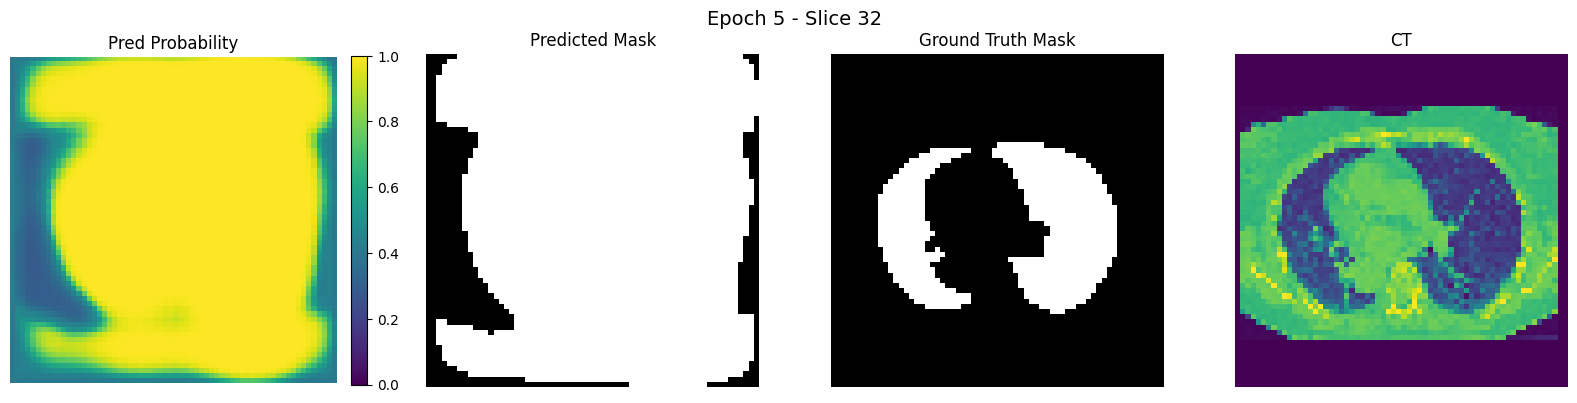

48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step - dice_coefficient: 0.3721 - iou_coefficient: 0.2316 - loss: 1.0833 - val_dice_coefficient: 0.2770 - val_iou_coefficient: 0.1640 - val_loss: 3.7574 - learning_rate: 5.0000e-04
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - dice_coefficient: 0.3609 - iou_coefficient: 0.2230 - loss: 1.0601 - val_dice_coefficient: 0.2910 - val_iou_coefficient: 0.1737 - val_loss: 3.9537 - learning_rate: 5.0000e-04
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - dice_coefficient: 0.3802 - iou_coefficient: 0.2372 - loss: 1.0364 - val_dice_coefficient: 0.3214 - val_iou_coefficient: 0.1963 - val_loss: 1.8653 - learning_rate: 5.0000e-04
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - dice_coefficient: 0.4087 - iou_coefficient: 0.2605 - loss: 0.9689 - val_dice_coefficient: 0.3470 - val_iou_coefficient: 0.2151 - val_loss: 1.9242 - learning_rate: 5.0000e-04
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 279ms/step - dice_coefficient: 0.4339 - iou_coeff

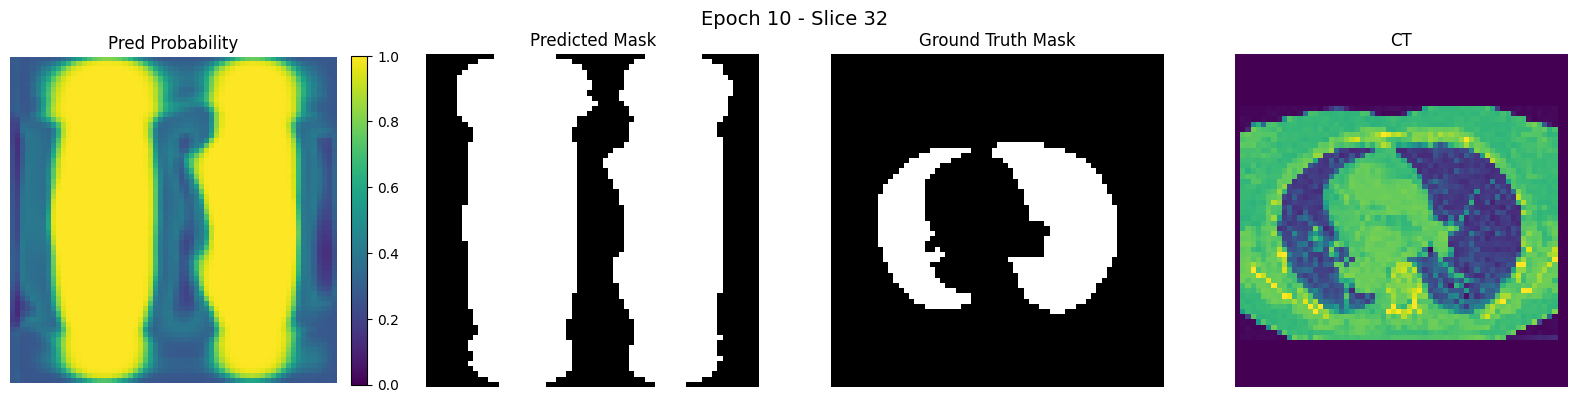

48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 316ms/step - dice_coefficient: 0.4217 - iou_coefficient: 0.2704 - loss: 0.9123 - val_dice_coefficient: 0.3208 - val_iou_coefficient: 0.1956 - val_loss: 2.6578 - learning_rate: 5.0000e-04
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - dice_coefficient: 0.4930 - iou_coefficient: 0.3308 - loss: 0.7819 - val_dice_coefficient: 0.4431 - val_iou_coefficient: 0.2900 - val_loss: 0.8832 - learning_rate: 5.0000e-04
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - dice_coefficient: 0.5056 - iou_coefficient: 0.3423 - loss: 0.7577 - val_dice_coefficient: 0.4482 - val_iou_coefficient: 0.2919 - val_loss: 0.8107 - learning_rate: 5.0000e-04
Epoch 13/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step - dice_coefficient: 0.5606 - iou_coefficient: 0.3938 - loss: 0.6522 - val_dice_coefficient: 0.4942 - val_iou_coefficient: 0.3344 - val_loss: 0.7541 - learning_rate: 5.0000e-04
Epoch 14/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 298ms/step - dice_coefficient: 0.5307 - iou_c

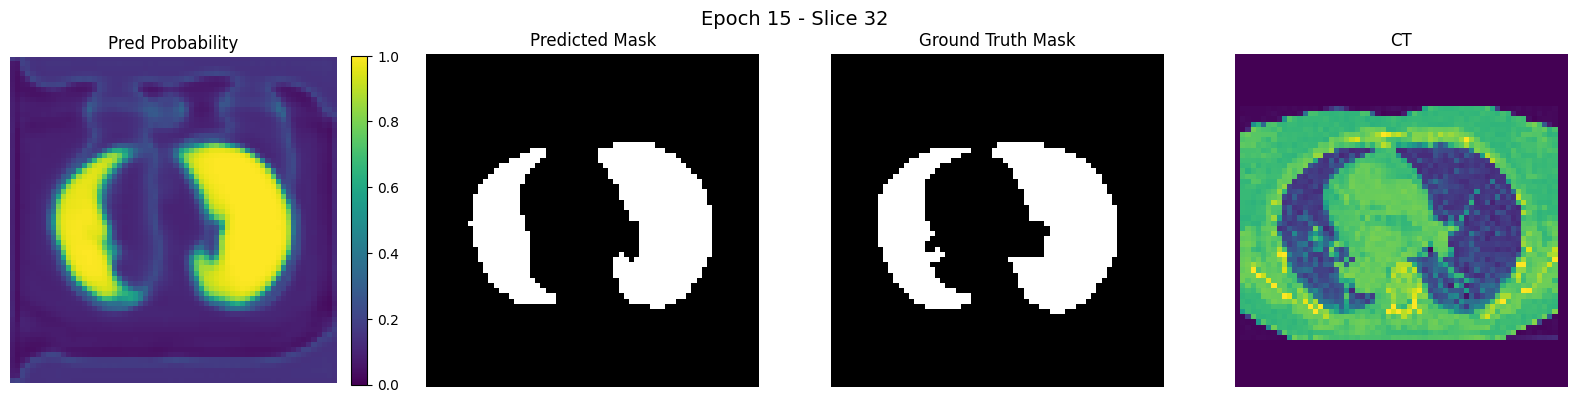

48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - dice_coefficient: 0.5370 - iou_coefficient: 0.3743 - loss: 0.6720 - val_dice_coefficient: 0.5682 - val_iou_coefficient: 0.4017 - val_loss: 0.5932 - learning_rate: 5.0000e-04
Epoch 16/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 257ms/step - dice_coefficient: 0.6115 - iou_coefficient: 0.4462 - loss: 0.5607 - val_dice_coefficient: 0.5590 - val_iou_coefficient: 0.3930 - val_loss: 0.6093 - learning_rate: 5.0000e-04
Epoch 17/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - dice_coefficient: 0.5995 - iou_coefficient: 0.4378 - loss: 0.6026 - val_dice_coefficient: 0.5703 - val_iou_coefficient: 0.4004 - val_loss: 0.5818 - learning_rate: 5.0000e-04
Epoch 18/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - dice_coefficient: 0.6533 - iou_coefficient: 0.4918 - loss: 0.5075 - val_dice_coefficient: 0.6359 - val_iou_coefficient: 0.4687 - val_loss: 0.4925 - learning_rate: 5.0000e-04
Epoch 19/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - dice_coefficient: 0.6872 - iou_c

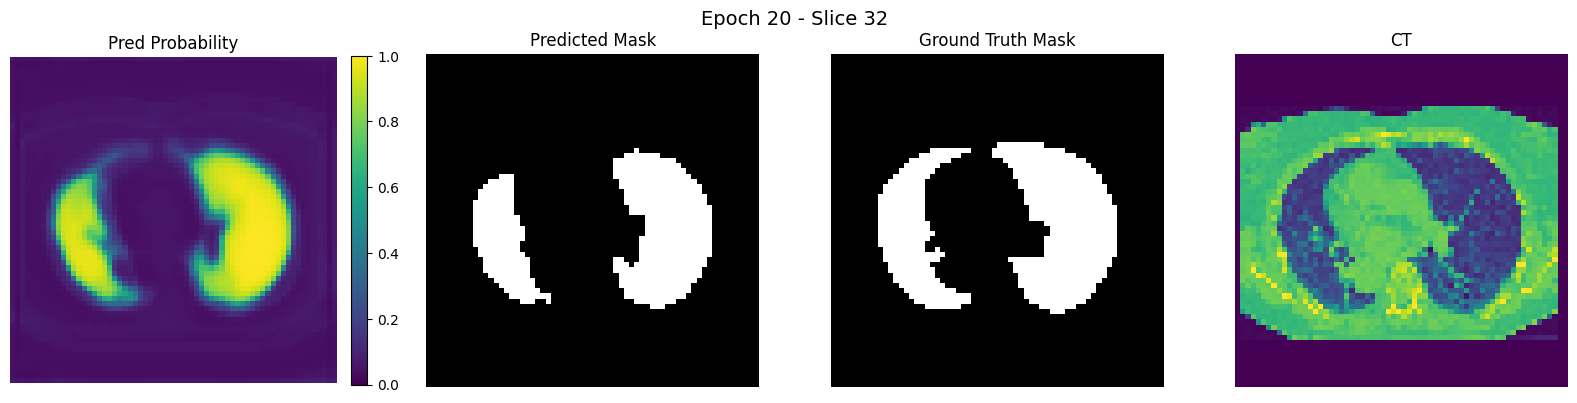

48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - dice_coefficient: 0.6882 - iou_coefficient: 0.5351 - loss: 0.4710 - val_dice_coefficient: 0.5068 - val_iou_coefficient: 0.3413 - val_loss: 0.6861 - learning_rate: 5.0000e-04
Epoch 21/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - dice_coefficient: 0.7017 - iou_coefficient: 0.5474 - loss: 0.4518 - val_dice_coefficient: 0.7276 - val_iou_coefficient: 0.5726 - val_loss: 0.3726 - learning_rate: 5.0000e-04
Epoch 22/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 272ms/step - dice_coefficient: 0.7103 - iou_coefficient: 0.5563 - loss: 0.4357 - val_dice_coefficient: 0.7302 - val_iou_coefficient: 0.5755 - val_loss: 0.3763 - learning_rate: 5.0000e-04
Epoch 23/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step - dice_coefficient: 0.7213 - iou_coefficient: 0.5729 - loss: 0.4124 - val_dice_coefficient: 0.6962 - val_iou_coefficient: 0.5346 - val_loss: 0.4319 - learning_rate: 5.0000e-04
Epoch 24/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - dice_coefficient: 0.7398 - iou_c

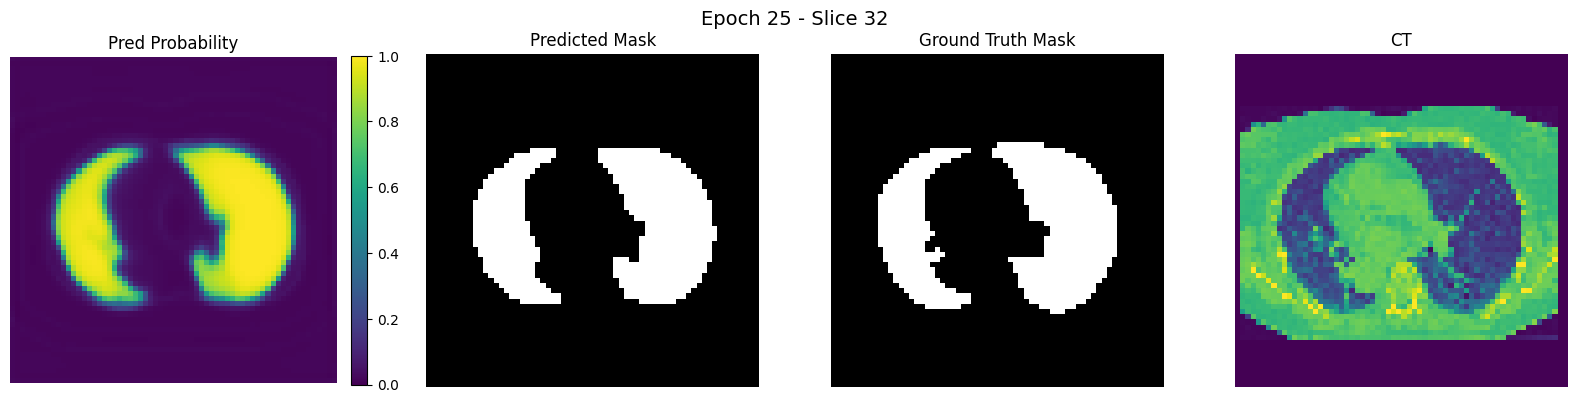

48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - dice_coefficient: 0.7276 - iou_coefficient: 0.5859 - loss: 0.4193 - val_dice_coefficient: 0.7390 - val_iou_coefficient: 0.5862 - val_loss: 0.3828 - learning_rate: 5.0000e-04
Epoch 26/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - dice_coefficient: 0.7500 - iou_coefficient: 0.6094 - loss: 0.3753 - val_dice_coefficient: 0.7050 - val_iou_coefficient: 0.5474 - val_loss: 0.4357 - learning_rate: 5.0000e-04
Epoch 27/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 244ms/step - dice_coefficient: 0.7542 - iou_coefficient: 0.6179 - loss: 0.3730 - val_dice_coefficient: 0.7863 - val_iou_coefficient: 0.6482 - val_loss: 0.3111 - learning_rate: 5.0000e-04
Epoch 28/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - dice_coefficient: 0.7798 - iou_coefficient: 0.6540 - loss: 0.3328 - val_dice_coefficient: 0.4028 - val_iou_coefficient: 0.2655 - val_loss: 0.9438 - learning_rate: 5.0000e-04
Epoch 29/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - dice_coefficient: 0.7300 - iou_c

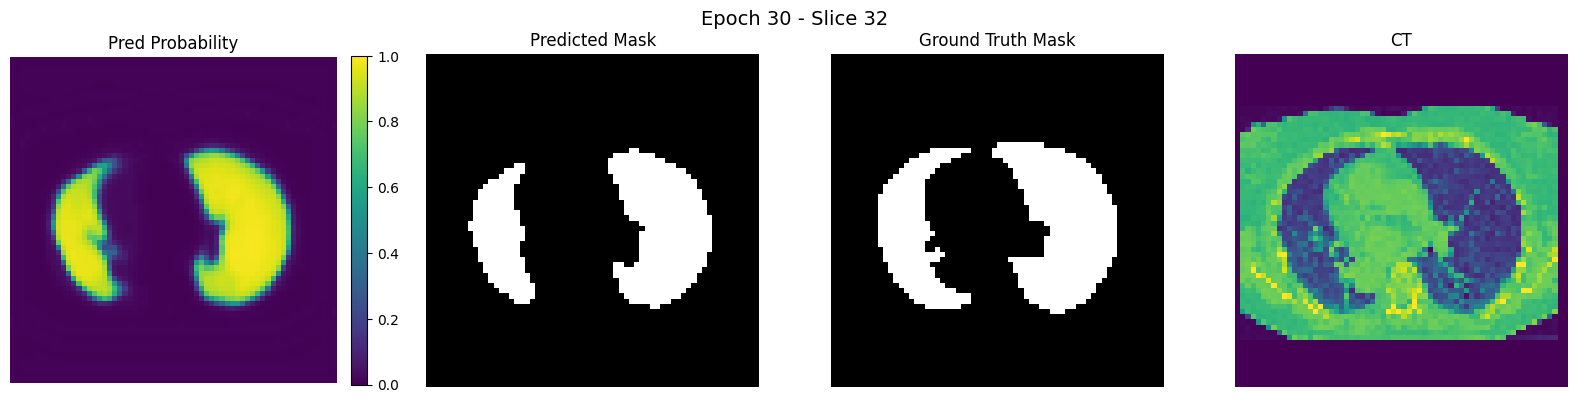

48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - dice_coefficient: 0.7483 - iou_coefficient: 0.6119 - loss: 0.4081 - val_dice_coefficient: 0.7435 - val_iou_coefficient: 0.5927 - val_loss: 0.3859 - learning_rate: 5.0000e-04
Epoch 31/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - dice_coefficient: 0.7270 - iou_coefficient: 0.5857 - loss: 0.4361 - val_dice_coefficient: 0.7168 - val_iou_coefficient: 0.5614 - val_loss: 0.4344 - learning_rate: 5.0000e-04
Epoch 32/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - dice_coefficient: 0.7746 - iou_coefficient: 0.6452 - loss: 0.3431 - val_dice_coefficient: 0.7960 - val_iou_coefficient: 0.6630 - val_loss: 0.3007 - learning_rate: 5.0000e-04
Epoch 33/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - dice_coefficient: 0.7184 - iou_coefficient: 0.5746 - loss: 0.4407 - val_dice_coefficient: 0.8239 - val_iou_coefficient: 0.7017 - val_loss: 0.2538 - learning_rate: 5.0000e-04
Epoch 34/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - dice_coefficient: 0.7995 - iou_c

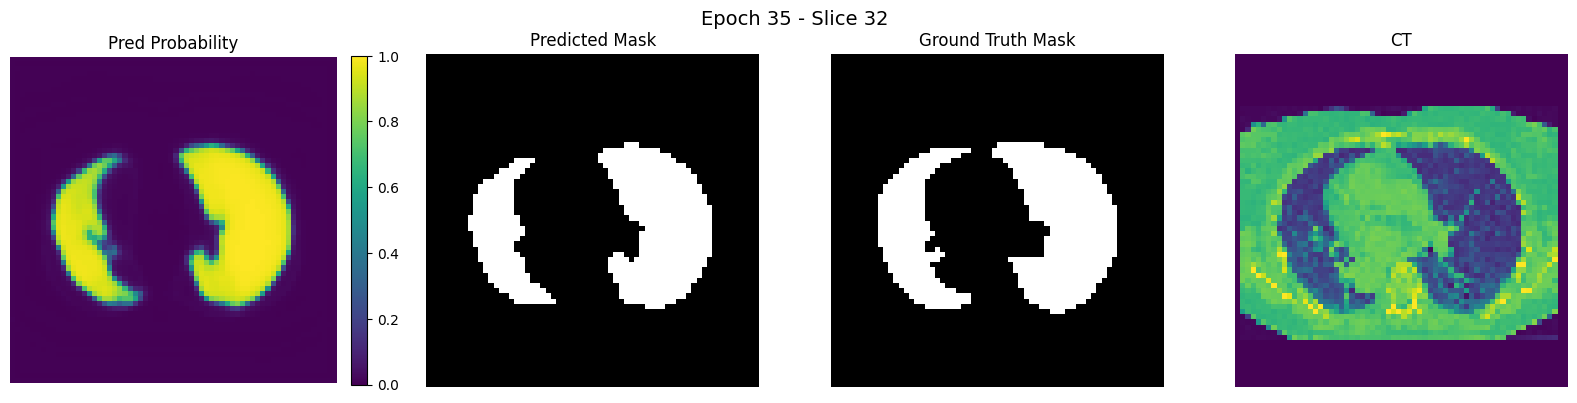

48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - dice_coefficient: 0.8057 - iou_coefficient: 0.6842 - loss: 0.2942 - val_dice_coefficient: 0.7179 - val_iou_coefficient: 0.5643 - val_loss: 0.4667 - learning_rate: 5.0000e-04
Epoch 36/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - dice_coefficient: 0.7800 - iou_coefficient: 0.6520 - loss: 0.3399 - val_dice_coefficient: 0.5353 - val_iou_coefficient: 0.3752 - val_loss: 0.7538 - learning_rate: 5.0000e-04
Epoch 37/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - dice_coefficient: 0.7633 - iou_coefficient: 0.6258 - loss: 0.3617 - val_dice_coefficient: 0.7739 - val_iou_coefficient: 0.6345 - val_loss: 0.3744 - learning_rate: 5.0000e-04
Epoch 38/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - dice_coefficient: 0.7918 - iou_coefficient: 0.6675 - loss: 0.3245 - val_dice_coefficient: 0.8875 - val_iou_coefficient: 0.7978 - val_loss: 0.1609 - learning_rate: 5.0000e-04
Epoch 39/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 272ms/step - dice_coefficient: 0.7815 - iou_c

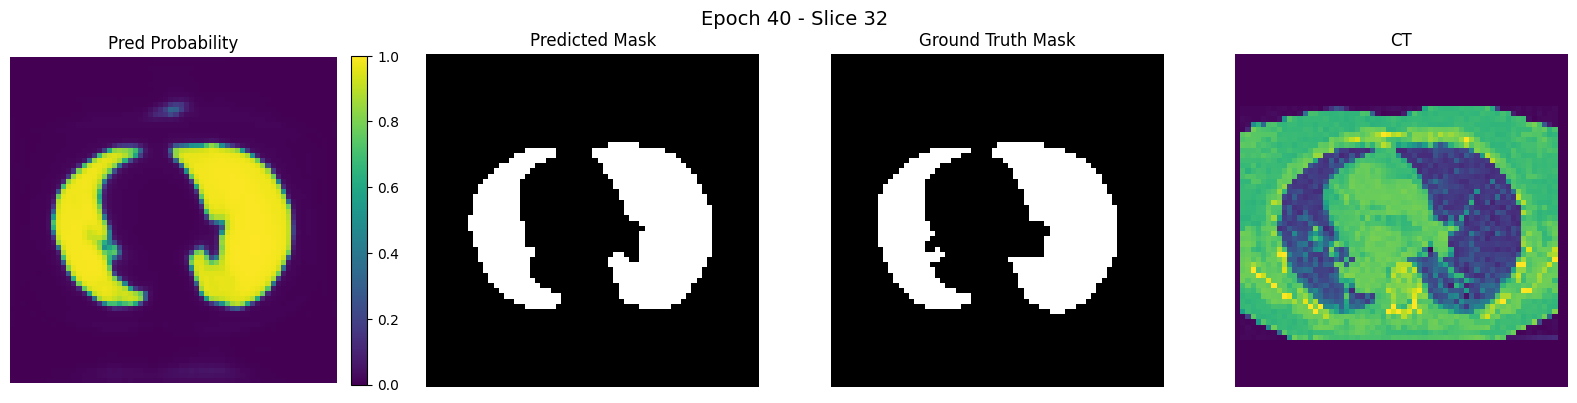

48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - dice_coefficient: 0.8038 - iou_coefficient: 0.6844 - loss: 0.3009 - val_dice_coefficient: 0.8751 - val_iou_coefficient: 0.7792 - val_loss: 0.1747 - learning_rate: 5.0000e-04
Epoch 41/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - dice_coefficient: 0.7733 - iou_coefficient: 0.6449 - loss: 0.3582 - val_dice_coefficient: 0.8505 - val_iou_coefficient: 0.7442 - val_loss: 0.2130 - learning_rate: 5.0000e-04
Epoch 42/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 266ms/step - dice_coefficient: 0.7479 - iou_coefficient: 0.6120 - loss: 0.4147 - val_dice_coefficient: 0.6261 - val_iou_coefficient: 0.4778 - val_loss: 0.6139 - learning_rate: 5.0000e-04
Epoch 43/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 288ms/step - dice_coefficient: 0.7495 - iou_coefficient: 0.6117 - loss: 0.4050 - val_dice_coefficient: 0.7374 - val_iou_coefficient: 0.5927 - val_loss: 0.4506 - learning_rate: 5.0000e-04
Epoch 44/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - dice_coefficient: 0.7758 - iou_co

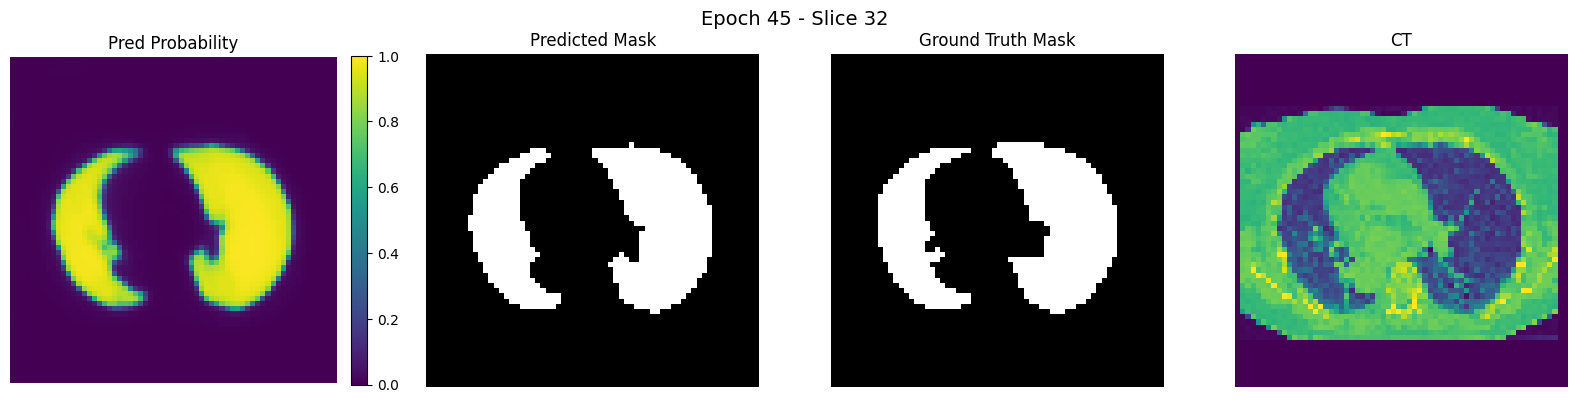

48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - dice_coefficient: 0.7539 - iou_coefficient: 0.6170 - loss: 0.3953 - val_dice_coefficient: 0.8324 - val_iou_coefficient: 0.7138 - val_loss: 0.2515 - learning_rate: 2.5000e-04
Epoch 46/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - dice_coefficient: 0.7767 - iou_coefficient: 0.6492 - loss: 0.3632 - val_dice_coefficient: 0.8710 - val_iou_coefficient: 0.7717 - val_loss: 0.1879 - learning_rate: 2.5000e-04
Epoch 47/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step - dice_coefficient: 0.7555 - iou_coefficient: 0.6235 - loss: 0.3923 - val_dice_coefficient: 0.8761 - val_iou_coefficient: 0.7796 - val_loss: 0.1800 - learning_rate: 2.5000e-04
Epoch 48/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - dice_coefficient: 0.8037 - iou_coefficient: 0.6847 - loss: 0.3034 - val_dice_coefficient: 0.8557 - val_iou_coefficient: 0.7481 - val_loss: 0.2136 - learning_rate: 2.5000e-04
Epoch 49/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - dice_coefficient: 0.8167 - iou_c

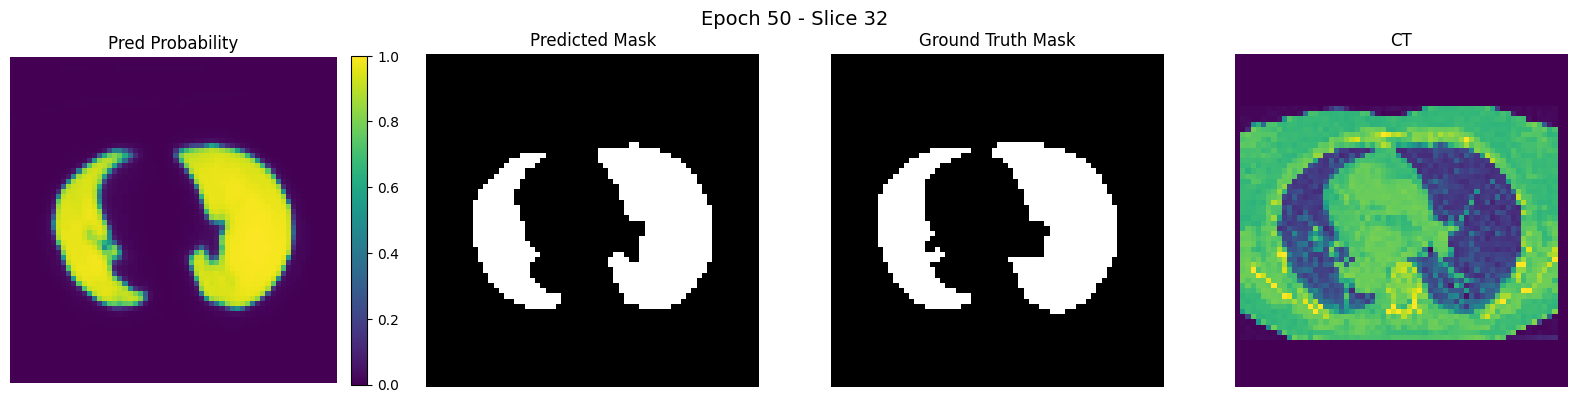

48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - dice_coefficient: 0.7647 - iou_coefficient: 0.6346 - loss: 0.3786 - val_dice_coefficient: 0.8026 - val_iou_coefficient: 0.6727 - val_loss: 0.3168 - learning_rate: 2.5000e-04
Epoch 51/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - dice_coefficient: 0.7899 - iou_coefficient: 0.6669 - loss: 0.3504 - val_dice_coefficient: 0.8003 - val_iou_coefficient: 0.6688 - val_loss: 0.3211 - learning_rate: 1.2500e-04
Epoch 52/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - dice_coefficient: 0.7944 - iou_coefficient: 0.6758 - loss: 0.3202 - val_dice_coefficient: 0.8167 - val_iou_coefficient: 0.6923 - val_loss: 0.2822 - learning_rate: 1.2500e-04
Epoch 53/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - dice_coefficient: 0.7350 - iou_coefficient: 0.5966 - loss: 0.4149 - val_dice_coefficient: 0.7817 - val_iou_coefficient: 0.6453 - val_loss: 0.3431 - learning_rate: 1.2500e-04
Epoch 53: early stopping
Restoring model weights from the end of the best epoch: 38.


In [15]:
################################################################################
# 10) Training
################################################################################

import tensorflow.keras.losses as Kloss

def bce_dice_loss(y_true, y_pred):
    bce = Kloss.binary_crossentropy(y_true, y_pred)
    dce = 1.0 - dice_coefficient(y_true, y_pred)  # dice_loss
    return bce + dce

# Instantiate Generators (train + val)
train_gen = LungDataGenerator(train_dirs, batch_size=1, augment=True, shuffle=True)
val_gen   = LungDataGenerator(val_dirs,   batch_size=1, augment=False, shuffle=False)

# Build the model
model = unet_3d_5levels(
    input_shape=(64,64,64,1),
    base_filters=16,
    dropout_rate=0.5,
    weight_decay=1e-5
)


model.compile(
    loss=bce_dice_loss,
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[dice_coefficient, iou_coefficient]
)

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_dice_coefficient',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_dice_coefficient',
    mode='max',
    factor=0.5,
    patience=6,
    min_lr=1e-7,
    verbose=1
)

# This callback will visualize predictions 5 epochs
val_plot_cb = ValidationPlotCallback(
    model,
    val_dir=val_dirs[1],  # pick the second validation patient
    epoch_freq=5,
    slice_idx=32
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[reduce_lr, early_stop, val_plot_cb],
    verbose=1
)


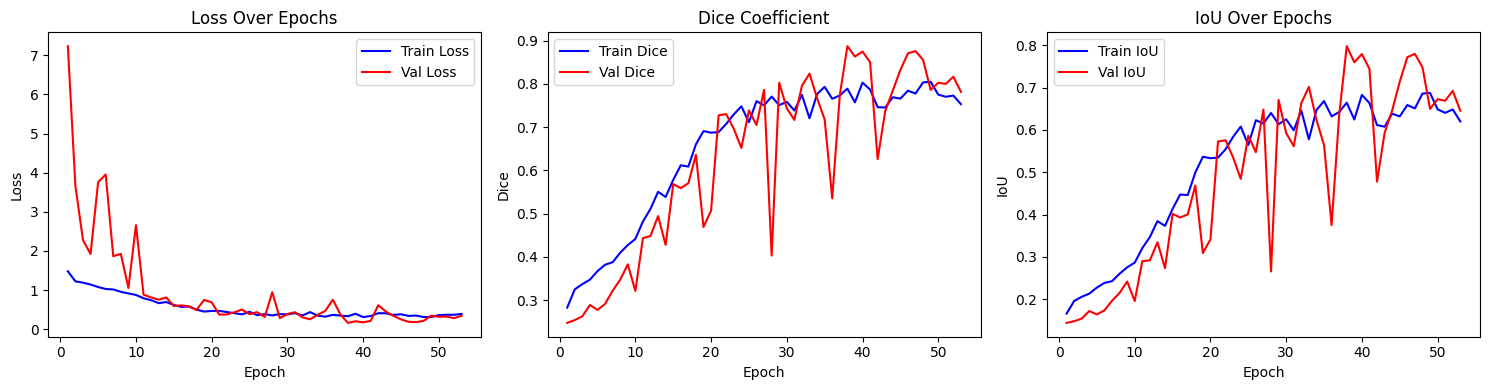

In [17]:
################################################################################
# 11) Plot Training/Validation Curves
################################################################################

train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_dice = history.history['dice_coefficient']
val_dice   = history.history['val_dice_coefficient']
train_iou  = history.history['iou_coefficient']
val_iou    = history.history['val_iou_coefficient']

epochs_ran = range(1, len(train_loss) + 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

# 1) Loss
axes[0].plot(epochs_ran, train_loss, 'b-', label='Train Loss')
axes[0].plot(epochs_ran, val_loss,   'r-', label='Val Loss')
axes[0].set_title("Loss Over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# 2) Dice
axes[1].plot(epochs_ran, train_dice, 'b-', label='Train Dice')
axes[1].plot(epochs_ran, val_dice,   'r-', label='Val Dice')
axes[1].set_title("Dice Coefficient")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Dice")
axes[1].legend()

# 3) IoU
axes[2].plot(epochs_ran, train_iou, 'b-', label='Train IoU')
axes[2].plot(epochs_ran, val_iou,   'r-', label='Val IoU')
axes[2].set_title("IoU Over Epochs")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("IoU")
axes[2].legend()

plt.show()
plt.close()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - dice_coefficient: 0.8859 - iou_coefficient: 0.7954 - loss: 0.1597
Test Loss        : 0.15859249234199524
Test Dice        : 0.8863844871520996
Test IoU         : 0.7962080836296082
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


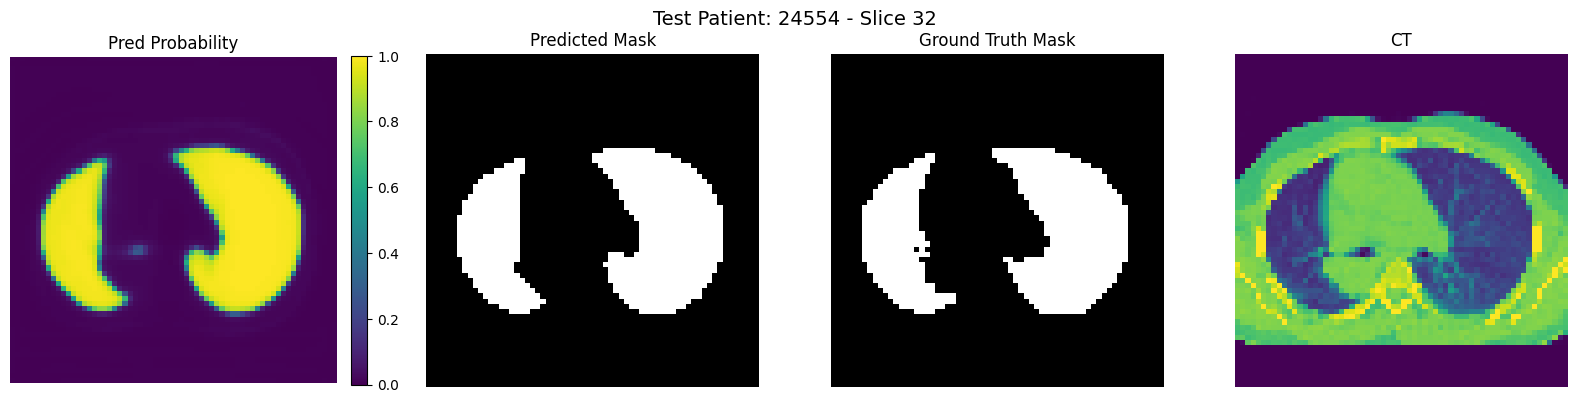

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


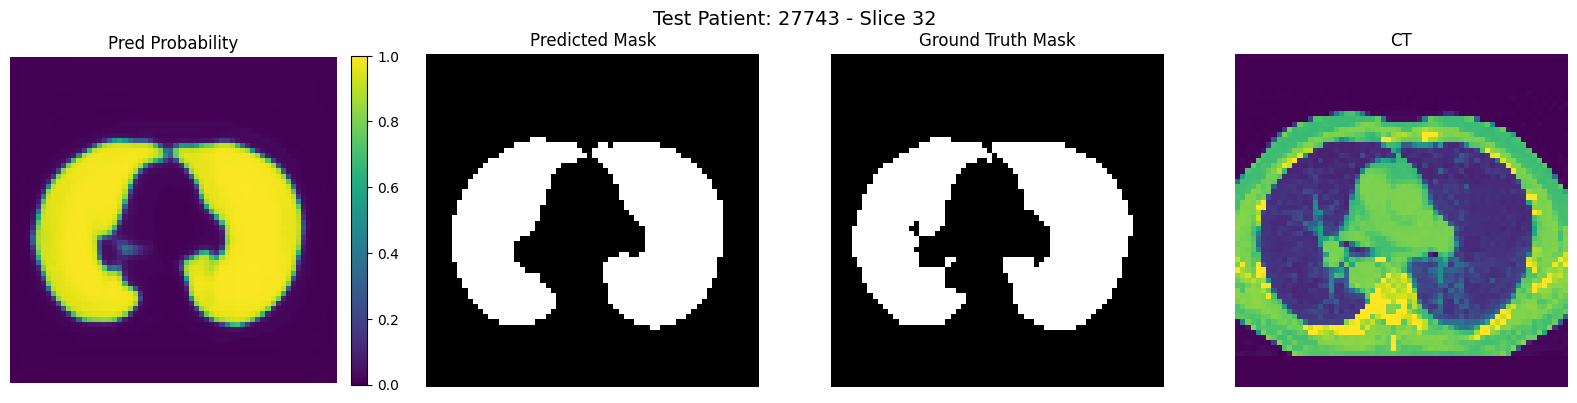

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


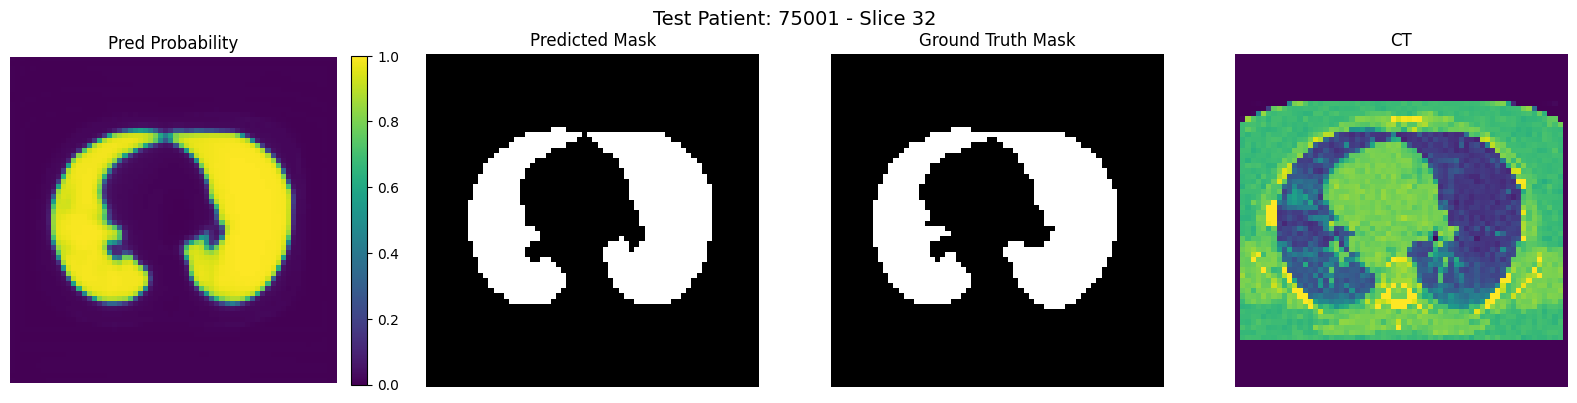

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


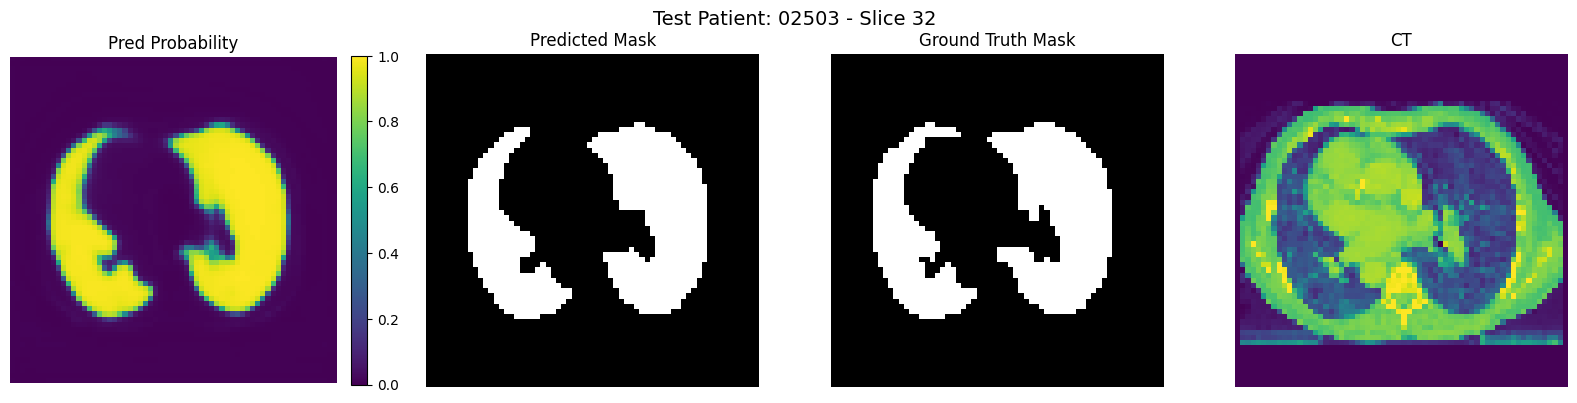

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


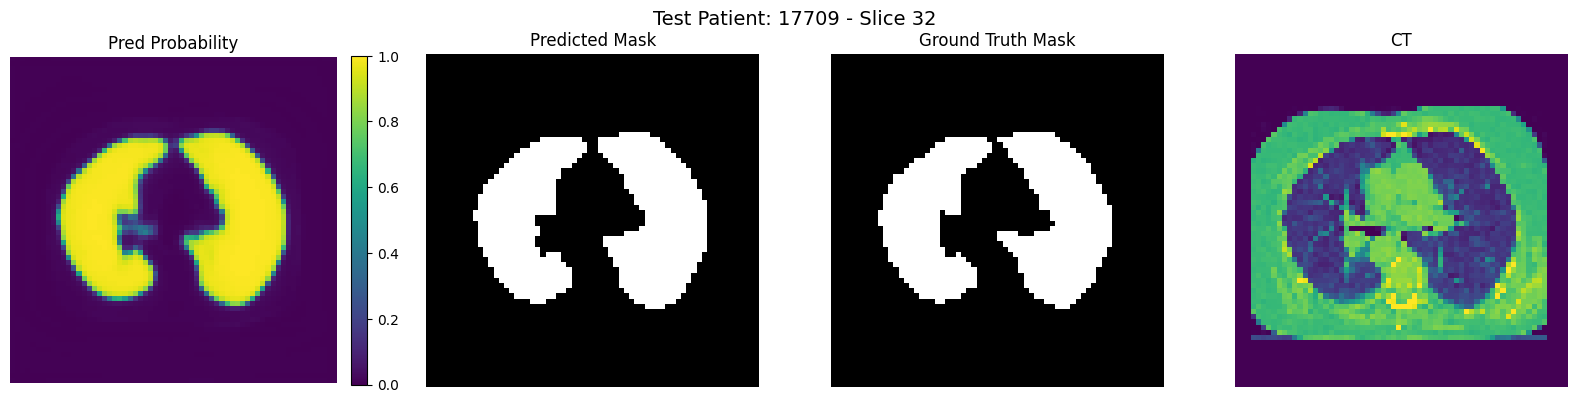

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


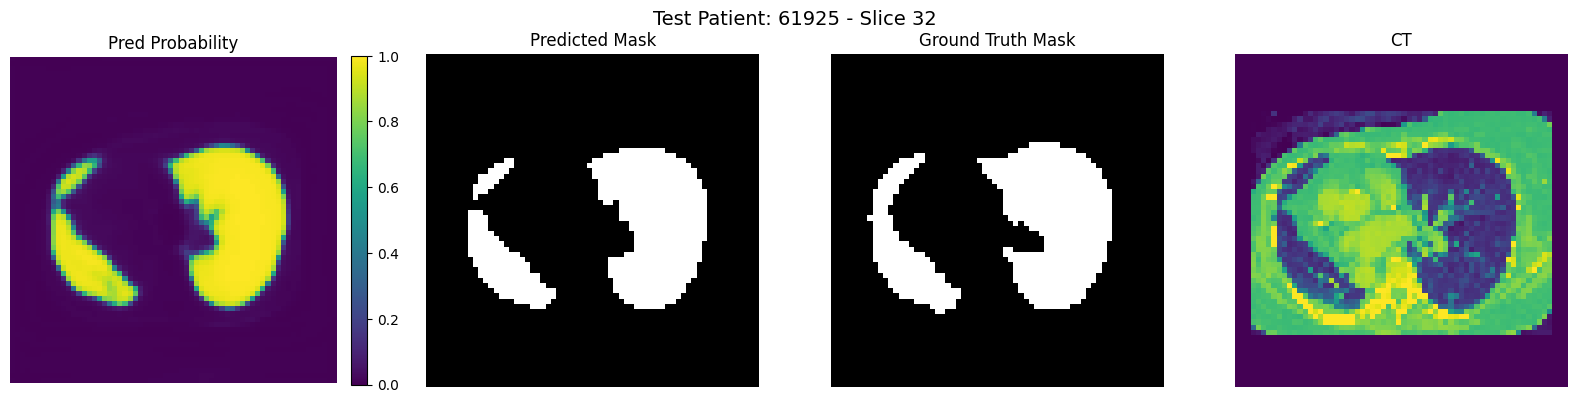

In [18]:
################################################################################
# 12) Final Test Evaluation & Visualization
################################################################################

# Evaluate on test set
test_gen = LungDataGenerator(test_dirs, batch_size=1, augment=False, shuffle=False)
test_results = model.evaluate(test_gen, verbose=1)
print("Test Loss        :", test_results[0])
print("Test Dice        :", test_results[1])
print("Test IoU         :", test_results[2])

# Visualize predictions on each test patient
for test_folder in test_dirs:
    folder_id = os.path.basename(test_folder)
    
    ct_path   = os.path.join(test_folder, "ct.nii")
    mask_path = os.path.join(test_folder, "lung.nii")
    
    ct_data   = nib.load(ct_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata()
    
    ct_data   = window_and_normalize(ct_data, -1000, 300)
    mask_data = (mask_data > 0).astype(np.float32)
    
    tmp = np.expand_dims(ct_data, axis=-1)  # (D,H,W,1)
    tmp = np.expand_dims(tmp, axis=0)       # (1,D,H,W,1)
    pred_prob = model.predict(tmp)[0]       # (D,H,W,1)
    pred_bin  = (pred_prob > 0.5).astype(np.float32)
    
    slice_idx = 32
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4), tight_layout=True)
    fig.suptitle(f"Test Patient: {folder_id} - Slice {slice_idx}", fontsize=14)
    
    # (1) Pred Probability
    im0 = axes[0].imshow(pred_prob[..., slice_idx, 0].T, 
                         origin='lower', vmin=0, vmax=1, cmap='viridis')
    axes[0].set_title("Pred Probability")
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    # (2) Predicted Mask
    axes[1].imshow(pred_bin[..., slice_idx, 0].T, origin='lower', cmap='gray')
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')
    
    # (3) Ground Truth Mask
    axes[2].imshow(mask_data[..., slice_idx].T, origin='lower', cmap='gray')
    axes[2].set_title("Ground Truth Mask")
    axes[2].axis('off')
    
    # (4) CT
    axes[3].imshow(ct_data[..., slice_idx].T, origin='lower', cmap='viridis')
    axes[3].set_title("CT")
    axes[3].axis('off')
    
    plt.show()
    plt.close()


# Save the model
model.save("lung_seg_model.h5")